In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt

In [10]:
import re
from nltk import FreqDist
import matplotlib.pyplot as plt
import re, string, unicodedata
import nltk
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
# Helper functions for preprocessing

def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

def remove_URL(sample):
    """Remove URLs from a sample string"""
    return re.sub(r"http\S+", "", sample)

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        if word.isdigit():
            continue
        else:
            new_words.append(word)
    return new_words


def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
    words = remove_stopwords(words)
    return words

def preprocess(sample):
    sample = remove_URL(sample)
    sample = replace_contractions(sample)
    # Tokenize
    words = nltk.word_tokenize(sample)

    # Normalize
    return normalize(words)

In [111]:
putin_mask = np.array(Image.open('/home/kjb/Desktop/DTU - Semester 4/DTU - Computational Social Science/02467-final/word-frequency/image-mask/p.png'))
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val
#t = np.vectorize(transform_format)(putin_mask)

In [18]:
import pandas as pd

path = '../data/dataframes/translated-text-ru-uk_sentiment.pkl'
df =pd.read_pickle(path)
# %%

df['date'] = pd.to_datetime(df['created_time'])
df.index = df['date']

# %%

def president_conversion(presidents):
    """
    0 -> No presidents
    1 -> putin
    2 -> zelenskyy
    3 -> putin and zelenskyy
    """
    return ('putin' in presidents) + ('zelenskyy' in presidents) * 2

df['president_mention_idx'] = np.vectorize(president_conversion)(df['president_mentioned'].to_numpy())

# three

def get_lang(df, lang):
    return df[(df['lang'] == lang).to_numpy()]

df_uk = get_lang(df, 'uk') 
df_ru = get_lang(df, 'ru')

def get_president_text(df, normalize=True):
    p_all = df[(df['president_mention_idx'] == 1).to_numpy()]
    p_text = " ".join(p_all['text'])
    
    z_all = df[(df['president_mention_idx'] == 2).to_numpy()]
    z_text = " ".join(z_all['text'])
    
    if normalize:
        p_text = preprocess(p_text)
        z_text = preprocess(z_text)
        p_text = " ".join(p_text)
        z_text = " ".join(z_text)
    
    return p_text, z_text


In [23]:
p_text, z_text = get_president_text(df_ru)

In [ ]:
# This box can probably be removed, since we can just say we create a mask of them, but idk
def convert(image):
    f = image.flatten()
    for i, pixel in enumerate(f):
        if pixel > 50:
            f[i] = 255
    return f.reshape(image.shape)
path = '/home/kjb/Desktop/DTU - Semester 4/DTU - Computational Social Science/02467-final/word-frequency/image-mask/putin-zelensky-2.jpg'
img = Image.open(path)
imgG = img.convert('L')
Image.fromarray(convert(np.array(imgG))).save('./img-mask.png')   

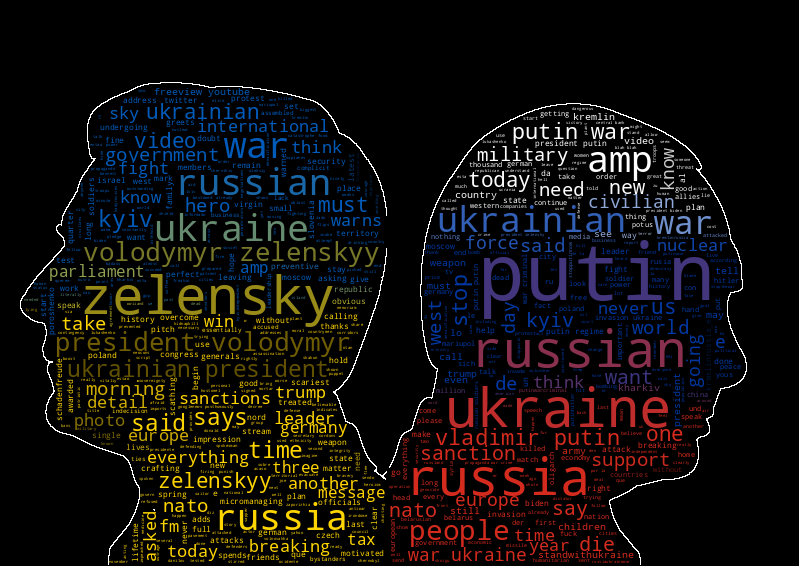

<Figure size 4000x4000 with 0 Axes>

<Figure size 4000x4000 with 0 Axes>

In [24]:
def color_wordcloud(image, color_image, text, visualize=True, background_color="black", contour_color='white', contour_width=1):
    wc = WordCloud(background_color=background_color, max_words=10000, mask=image,
                    contour_width=contour_width,mode='RGB',width=500,height=500, contour_color=contour_color).generate(text)
    image_colors = ImageColorGenerator(color_image)
    plt.figure(figsize=[40,40],dpi=100)
    word_cloud = wc.recolor(color_func=image_colors)
    if visualize:
        plt.imshow(word_cloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
        plt.close()
    return word_cloud

# change these paths later
path = '/home/kjb/Desktop/DTU - Semester 4/DTU - Computational Social Science/02467-final/word-frequency/image-mask/p.png'
putin_mask = np.array(Image.open(path))
path_color = '/home/kjb/Desktop/DTU - Semester 4/DTU - Computational Social Science/02467-final/word-frequency/image-mask/p-color.png'
putin_color = np.array(Image.open(path_color))

p_word = color_wordcloud(putin_mask, putin_color, p_text, visualize=False)

# change these paths later
path = '/home/kjb/Desktop/DTU - Semester 4/DTU - Computational Social Science/02467-final/word-frequency/image-mask/z.png'
z_img = np.array(Image.open(path))
path_color = '/home/kjb/Desktop/DTU - Semester 4/DTU - Computational Social Science/02467-final/word-frequency/image-mask/z-color.png'
z_color = np.array(Image.open(path_color))

z_word = color_wordcloud(z_img, z_color, z_text, visualize=False)

def extend_image(images):
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    return new_im

images = [z_word.to_image(),p_word.to_image()]
new_im = extend_image(images)
new_im.save('/home/kjb/Desktop/DTU - Semester 4/DTU - Computational Social Science/02467-final/word-frequency/image-mask/z_p.png')
new_im

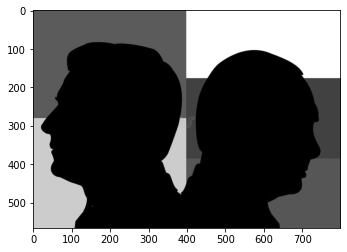

In [50]:
img = Image.open(path)
imgG = img.convert('L')
plt.imshow(imgG,cmap='gray')


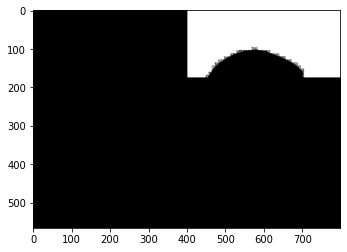

In [68]:
def trasnform(pixel):
    return 255 if pixel != 0 else 255

res = np.vectorize(transform)(np.array(imgG))
plt.imshow(res,cmap='gray')

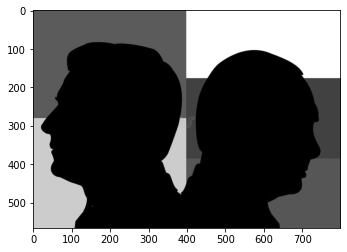

In [62]:
plt.imshow(np.array(imgG),cmap='gray')

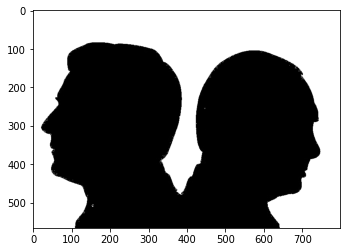

In [82]:
plt.imshow(convert(np.array(imgG)),cmap='gray')

In [105]:
Image.fromarray(convert(np.array(imgG))).save('./img-mask.png')